In [ ]:
!pip install datasets transformers scikit-learn pandas joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Data Preprocessing


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from datasets import load_dataset
import pickle
import joblib

# Load the GoEmotions dataset using Hugging Face Datasets library
dataset = load_dataset("go_emotions")

# Convert datasets to pandas DataFrames
train_df = dataset['train'].to_pandas()
validation_df = dataset['validation'].to_pandas()
test_df = dataset['test'].to_pandas()

# Function to preprocess data by filtering multi-label samples
def preprocess_data(df):
    # Filter out multi-label samples
    df = df[df['labels'].apply(lambda x: len(x) == 1)].copy()
    # Extract the single label
    df['label'] = df['labels'].apply(lambda x: x[0])
    df = df.reset_index(drop=True)
    return df

# Preprocess train, validation, and test datasets
train_data = preprocess_data(train_df)
validation_data = preprocess_data(validation_df)
test_data = preprocess_data(test_df)

# Vectorization for Baseline Models with Enhanced Preprocessing
vectorizer = CountVectorizer(
    stop_words='english',     # Remove stop words
    ngram_range=(1, 2),       # Include unigrams and bigrams
    max_features=5000         # Limit to top 5000 features
)

# Fit the vectorizer on the training data and transform
X_train_baseline = vectorizer.fit_transform(train_data['text'])
X_validation_baseline = vectorizer.transform(validation_data['text'])
X_test_baseline = vectorizer.transform(test_data['text'])

y_train_baseline = train_data['label'].values
y_validation_baseline = validation_data['label'].values
y_test_baseline = test_data['label'].values

# Save processed data for further use
processed_data = {
    "baseline": {
        "X_train": X_train_baseline,
        "y_train": y_train_baseline,
        "X_validation": X_validation_baseline,
        "y_validation": y_validation_baseline,
        "X_test": X_test_baseline,
        "y_test": y_test_baseline,
    }
}

# Save to a file for later use
with open("processed_data.pkl", "wb") as f:
    pickle.dump(processed_data, f)

# Save the vectorizer separately
joblib.dump(vectorizer, 'vectorizer.joblib')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.40k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/350k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

['vectorizer.joblib']

# Mini BERT Model for Emotion Classification

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoConfig, AutoTokenizer

# Define the Small-BERT model
class SmallBERT(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_heads, num_layers, max_seq_len, intermediate_size):
        super(SmallBERT, self).__init__()

        # Embedding layers
        self.token_embeddings = nn.Embedding(vocab_size, hidden_size)
        self.position_embeddings = nn.Embedding(max_seq_len, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(0.1)

        # Transformer layers
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads, intermediate_size) for _ in range(num_layers)
        ])

        # Output layer for MLM
        self.mlm_head = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_ids, return_logits=False):
        # Embedding layer
        seq_len = input_ids.size(1)
        positions = torch.arange(seq_len, device=input_ids.device).unsqueeze(0)
        x = self.token_embeddings(input_ids) + self.position_embeddings(positions)
        x = self.layer_norm(x)
        x = self.dropout(x)

        # Pass through transformer blocks
        for block in self.transformer_blocks:
            x = block(x)

        # By default, return hidden states
        if return_logits:
            # If return_logits=True, return MLM logits
            logits = self.mlm_head(x)
            return logits
        else:
            # Return just the hidden states
            return x

class TransformerBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, intermediate_size):
        super(TransformerBlock, self).__init__()

        # Self-attention layer
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads, dropout=0.1)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.dropout1 = nn.Dropout(0.1)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(hidden_size, intermediate_size),
            nn.GELU(),
            nn.Linear(intermediate_size, hidden_size),
        )
        self.norm2 = nn.LayerNorm(hidden_size)
        self.dropout2 = nn.Dropout(0.1)

    def forward(self, x):
        # Self-attention
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + self.dropout1(attn_output))

        # Feed-forward
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout2(ffn_output))

        return x

# Define testing function
def test_models(small_model, small_config, bert_base_model_name="bert-base-uncased"):
    # Load the pre-trained BERT-base model and its configuration
    bert_base = AutoModel.from_pretrained(bert_base_model_name)
    bert_base_config = AutoConfig.from_pretrained(bert_base_model_name)
    bert_base_config_dict = bert_base_config.to_dict()
    tokenizer = AutoTokenizer.from_pretrained(bert_base_model_name)

    print("\n--- Comparing Architectures ---\n")
    print("BERT-base architecture:")
    print(bert_base)
    print("\nSmall-BERT architecture:")
    print(small_model)

    print("\n--- Counting Parameters ---\n")
    bert_base_params = sum(p.numel() for p in bert_base.parameters() if p.requires_grad)
    small_params = sum(p.numel() for p in small_model.parameters() if p.requires_grad)
    print(f"BERT-base parameter count: {bert_base_params}")
    print(f"Small-BERT parameter count: {small_params}")

    print("\n--- Comparing Configurations ---\n")
    for key in small_config:
        bert_value = bert_base_config_dict.get(key, "N/A")
        small_value = small_config[key]
        print(f"{key}: BERT-base={bert_value}, Small-BERT={small_value}")

    print("\n--- Inspecting Embedding Shapes ---\n")
    bert_embedding_shape = bert_base.embeddings.word_embeddings.weight.shape
    small_embedding_shape = small_model.token_embeddings.weight.shape
    print(f"BERT-base embedding shape: {bert_embedding_shape}")
    print(f"Small-BERT embedding shape: {small_embedding_shape}")

    print("\n--- Running a Forward Pass ---\n")
    input_text = "This is a test sentence."
    inputs = tokenizer(input_text, return_tensors="pt", max_length=128, truncation=True, padding="max_length")

    # Run through BERT-base: it returns last_hidden_state by default
    with torch.no_grad():
        bert_outputs = bert_base(**inputs)
    print(f"BERT-base output shape: {bert_outputs.last_hidden_state.shape}")

    # Run through Small-BERT: now returns hidden states by default
    with torch.no_grad():
        small_outputs = small_model(inputs["input_ids"])
    print(f"Small-BERT output shape: {small_outputs.shape}")

    # Verify MLM logits
    logits = small_model(inputs["input_ids"], return_logits=True)
    print(f"Small-BERT MLM logits shape: {logits.shape}")

    print("\n--- Validation Complete ---")

# Initialize Small-BERT model
small_model = SmallBERT(
    vocab_size=30522, hidden_size=256, num_heads=4, num_layers=4, max_seq_len=128, intermediate_size=1024
)

# Small-BERT configuration
small_config = {
    "vocab_size": 30522,
    "hidden_size": 256,
    "num_attention_heads": 4,
    "num_hidden_layers": 4,
    "intermediate_size": 1024,
    "max_position_embeddings": 128,
}

# Run the test
test_models(small_model, small_config)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


--- Comparing Architectures ---

BERT-base architecture:
BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AdamW
from tqdm import tqdm

class SmallBERTForSequenceClassification(nn.Module):
    def __init__(self, small_bert, num_classes):
        super(SmallBERTForSequenceClassification, self).__init__()
        self.small_bert = small_bert
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask=None):
        hidden_states = self.small_bert(input_ids, return_logits=False)
        cls_embedding = hidden_states[:, 0, :]
        logits = self.classifier(cls_embedding)
        return logits


class GoEmotionsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        return input_ids, attention_mask, label


num_classes = len(train_data['label'].unique())

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_dataset = GoEmotionsDataset(train_data['text'], train_data['label'], tokenizer)
val_dataset = GoEmotionsDataset(validation_data['text'], validation_data['label'], tokenizer)
test_dataset = GoEmotionsDataset(test_data['text'], test_data['label'], tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize Small-BERT
small_bert = SmallBERT(
    vocab_size=30522,
    hidden_size=256,
    num_heads=4,
    num_layers=4,
    max_seq_len=128,
    intermediate_size=1024
)

model = SmallBERTForSequenceClassification(small_bert, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            logits = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total

    print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.4f}")

# Save the trained model
torch.save(model.state_dict(), "small_bert_model.pth")
print("Model saved to 'small_bert_model.pth'")

# Test
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        logits = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

Training Epoch 1/3: 100%|██████████| 1135/1135 [00:48<00:00, 23.32it/s]


Epoch: 1, Train Loss: 2.6208, Val Acc: 0.3500


Training Epoch 2/3: 100%|██████████| 1135/1135 [00:47<00:00, 24.09it/s]


Epoch: 2, Train Loss: 2.6078, Val Acc: 0.3500


Training Epoch 3/3: 100%|██████████| 1135/1135 [00:47<00:00, 23.98it/s]


Epoch: 3, Train Loss: 2.6072, Val Acc: 0.3500
Model saved to 'small_bert_model.pth'
Test Accuracy: 0.3499


## Confusion Matrix for Mini Bert

Predicting on the test set.
Computing the confusion matrix.
Confusion Matrix:
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0  348]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0  186]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0  131]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0  194]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0  236]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0   86]
 [   0    0    0    0    0    0    0    0    0    0 

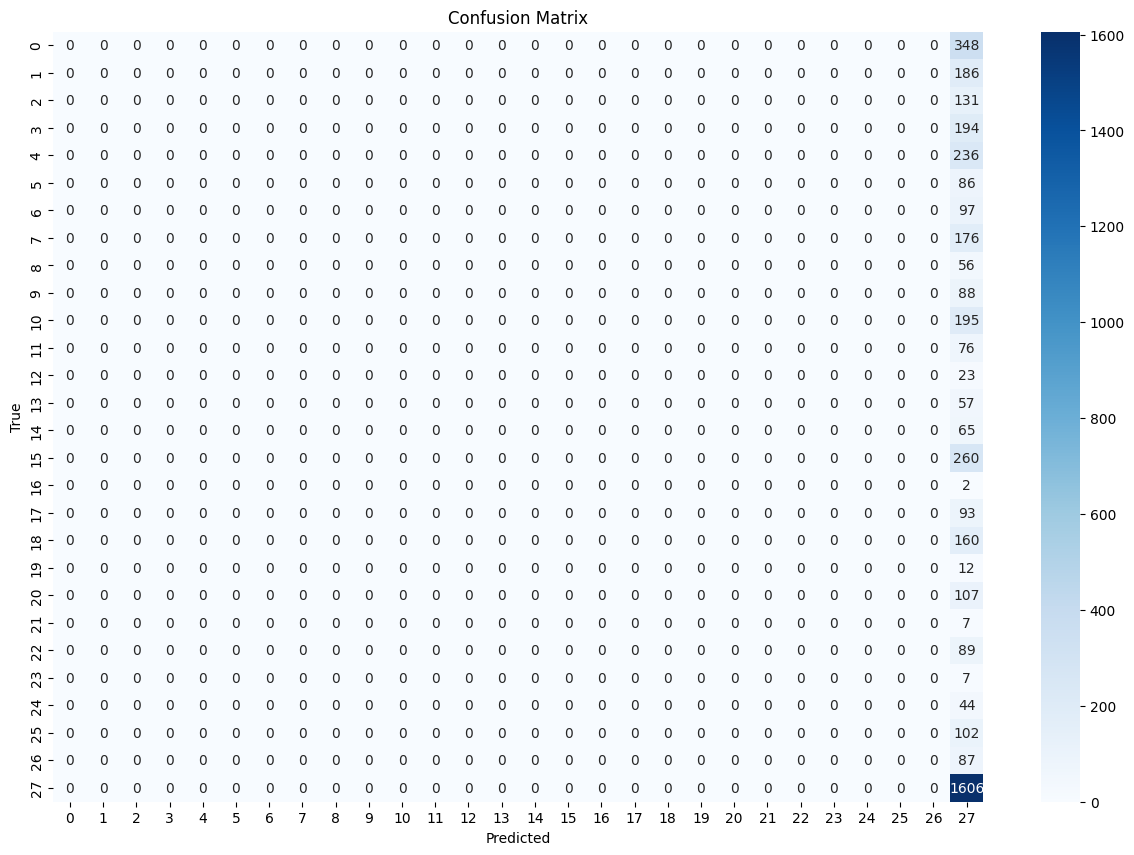

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Collect predictions and true labels from the test set
print("Predicting on the test set.")
y_test = []
y_pred = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        logits = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(logits, dim=1)

        y_test.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Compute the confusion matrix
print("Computing the confusion matrix.")
conf_matrix = confusion_matrix(y_test, y_pred)

# Get sorted unique labels
labels = sorted(set(y_test))

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Precision & Recall & F1 score

### Overall

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Collect predictions and true labels from the test set
print("Predicting on the test set.")
y_test = []
y_pred = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        logits = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(logits, dim=1)

        y_test.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Compute weighted metrics with zero_division=0
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Predicting on the test set.
Precision: 0.1224
Recall: 0.3499
F1 Score: 0.1814


### By Class

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Collect predictions and true labels from the test set
print("Predicting on the test set.")
y_test = []
y_pred = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        logits = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(logits, dim=1)

        y_test.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Calculate per-class precision, recall, and F1 scores
print("Calculating per-class precision, recall, and F1 scores.")
precision_per_class = precision_score(y_test, y_pred, average=None, zero_division=0)
recall_per_class = recall_score(y_test, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_test, y_pred, average=None, zero_division=0)

# Get unique class labels
class_labels = sorted(set(y_test))

# Print per-class metrics
print("Per-Class Metrics (Mini BERT):")
for label, p, r, f in zip(class_labels, precision_per_class, recall_per_class, f1_per_class):
    print(f"Class {label}: Precision={p:.4f}, Recall={r:.4f}, F1 Score={f:.4f}")

Predicting on the test set.
Calculating per-class precision, recall, and F1 scores.
Per-Class Metrics (Mini BERT):
Class 0: Precision=0.0000, Recall=0.0000, F1 Score=0.0000
Class 1: Precision=0.0000, Recall=0.0000, F1 Score=0.0000
Class 2: Precision=0.0000, Recall=0.0000, F1 Score=0.0000
Class 3: Precision=0.0000, Recall=0.0000, F1 Score=0.0000
Class 4: Precision=0.0000, Recall=0.0000, F1 Score=0.0000
Class 5: Precision=0.0000, Recall=0.0000, F1 Score=0.0000
Class 6: Precision=0.0000, Recall=0.0000, F1 Score=0.0000
Class 7: Precision=0.0000, Recall=0.0000, F1 Score=0.0000
Class 8: Precision=0.0000, Recall=0.0000, F1 Score=0.0000
Class 9: Precision=0.0000, Recall=0.0000, F1 Score=0.0000
Class 10: Precision=0.0000, Recall=0.0000, F1 Score=0.0000
Class 11: Precision=0.0000, Recall=0.0000, F1 Score=0.0000
Class 12: Precision=0.0000, Recall=0.0000, F1 Score=0.0000
Class 13: Precision=0.0000, Recall=0.0000, F1 Score=0.0000
Class 14: Precision=0.0000, Recall=0.0000, F1 Score=0.0000
Class 15: 

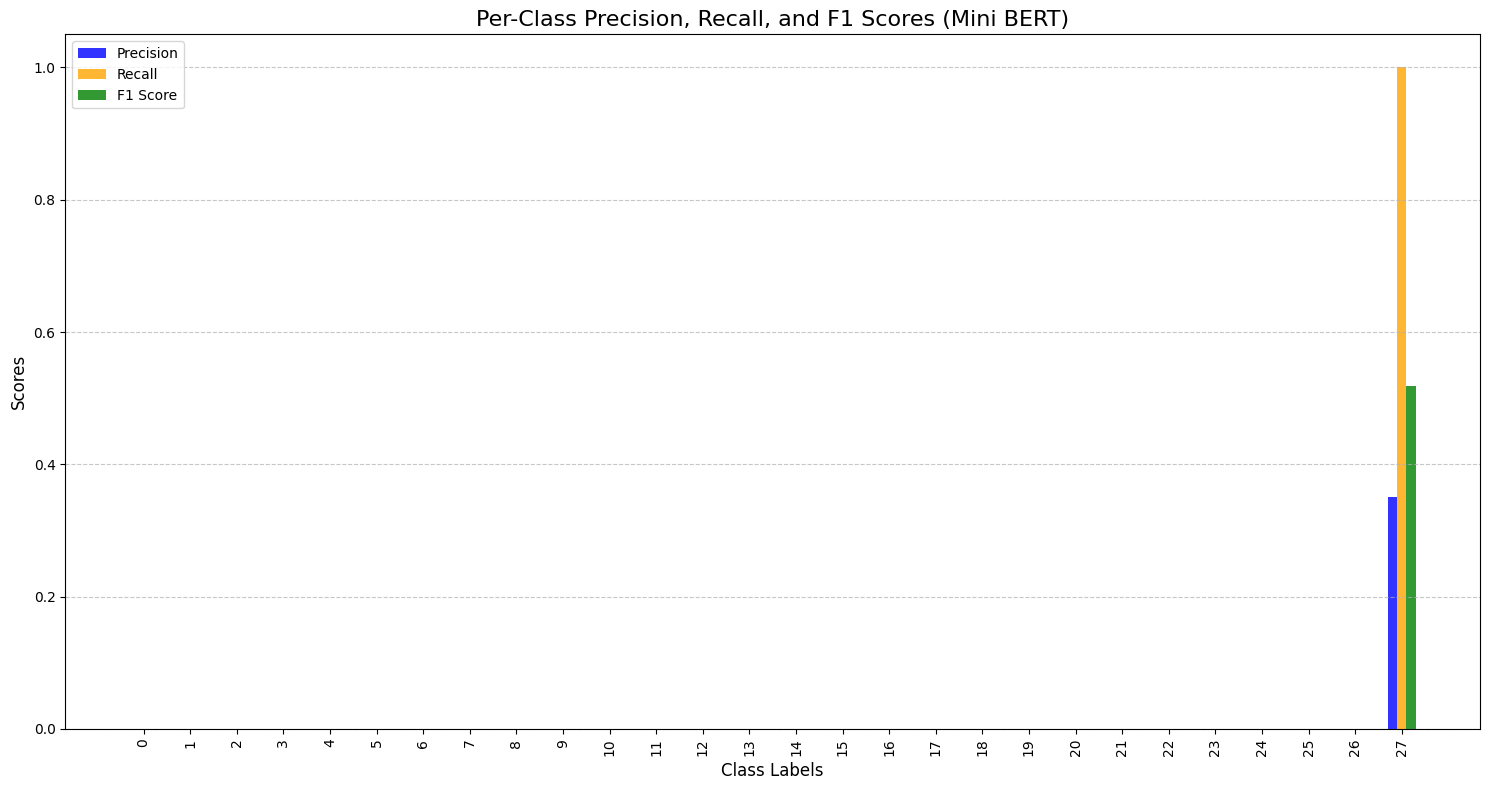

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a bar plot for precision, recall, and F1 scores per class
x = np.arange(len(class_labels))  # Class indices

# Set the width of the bars
bar_width = 0.2

# Create the bar plots
plt.figure(figsize=(15, 8))
plt.bar(x - bar_width, precision_per_class, bar_width, label='Precision', alpha=0.8, color='blue')
plt.bar(x, recall_per_class, bar_width, label='Recall', alpha=0.8, color='orange')
plt.bar(x + bar_width, f1_per_class, bar_width, label='F1 Score', alpha=0.8, color='green')

# Add labels, title, and legend
plt.xlabel('Class Labels', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Per-Class Precision, Recall, and F1 Scores (Mini BERT)', fontsize=16)
plt.xticks(x, class_labels, rotation=90)  # Rotate class labels for better readability
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
from google.colab import files
files.download('small_bert_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>